In [1]:
"""
i want to create a fun platform that is able to take in an image and turn it into a valid maze (the maze would be rectangular/circular, and the solution would draw the original image). to do so, i'm guessing i'll need to following modules (can add or combine as necessary, whatever is most efficient):

1. data ingestion - pretty simple, prompt the user for an image

2. data processing - turn the raw image into lines that could form a maze (using some image processing tool or machine learning? not sure how to accomplish this)

3. turn processed data into a valid maze - not sure if there's an algorithm that, given lines, is able to create a maze? other ideas could work and be helpful

4. qol - show the maze's solution
"""

"\ni want to create a fun platform that is able to take in an image and turn it into a valid maze (the maze would be rectangular/circular, and the solution would draw the original image). to do so, i'm guessing i'll need to following modules (can add or combine as necessary, whatever is most efficient):\n\n1. data ingestion - pretty simple, prompt the user for an image\n\n2. data processing - turn the raw image into lines that could form a maze (using some image processing tool or machine learning? not sure how to accomplish this)\n\n3. turn processed data into a valid maze - not sure if there's an algorithm that, given lines, is able to create a maze? other ideas could work and be helpful\n\n4. qol - show the maze's solution\n"

In [2]:
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import deque

In [3]:
# visualization helper function
def display_image(title, image):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

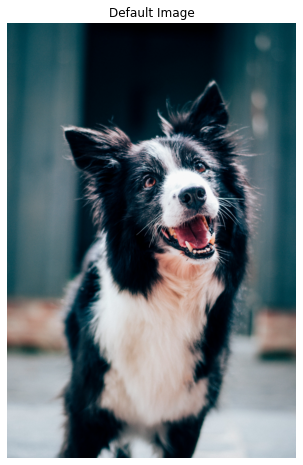

In [4]:
def ingest_image():
    # TODO: prompt for file
    file_path = "image.jpg"
    
    # validate file
    if not os.path.exists(file_path):
        print("Error: File not found.")
        return None
    supported_formats = (".jpg", ".jpeg", ".png", ".bmp")
    if not file_path.lower().endswith(supported_formats):
        print(f"Error: Unsupported file format. Please use {', '.join(supported_formats)}.")
        return None

    try:
        # open and preprocess the image
        with Image.open(file_path) as img:
            # greyscale images
            img = img.convert("RGB")
            img.thumbnail((800, 800))  # resize to manageable size
            return img
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

image = ingest_image()
if image:
    display_image('Default Image', image)

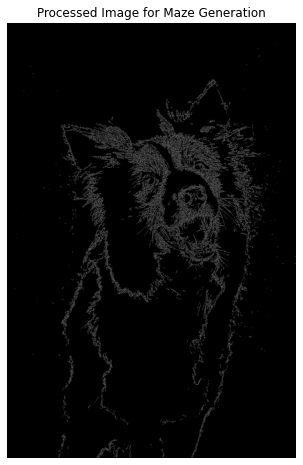

In [5]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Error: Image not found or unsupported format.")
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # gaussian blur = noise reduction
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # canny edge detection
    edges = cv2.Canny(blurred, threshold1=20, threshold2=60)

    # dilation + erosion
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    cleaned = cv2.erode(dilated, kernel, iterations=1)

    # skeletonize
    skeleton = cv2.ximgproc.thinning(cleaned, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

    return skeleton

file_path = "image.jpg"  # Replace with your image path
processed_image = preprocess_image(file_path)
display_image("Processed Image for Maze Generation", processed_image)

In [6]:
def skeleton_to_binary(skeleton):
    """
    Convert the skeleton image to a binary image.

    Args:
        skeleton (numpy.ndarray): Skeletonized image.

    Returns:
        binary_image (numpy.ndarray): Binary image (1 for paths, 0 for walls).
    """
    # Threshold the skeleton image
    _, binary_image = cv2.threshold(skeleton, 1, 1, cv2.THRESH_BINARY)
    return binary_image

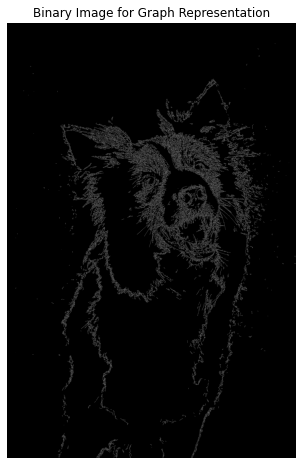

In [7]:
binary_image = skeleton_to_binary(processed_image)
display_image("Binary Image for Graph Representation", binary_image)

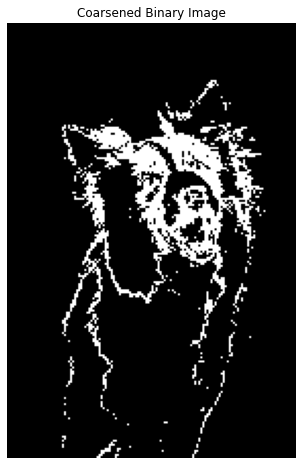

In [8]:
def coarsen_binary_image(binary_image, block_size, threshold=0.1):
    """
    Simplify a binary image by grouping into blocks and determining block values.

    Args:
        binary_image (numpy.ndarray): Original binary image (1 for paths, 0 for walls).
        block_size (int): Size of the square block (e.g., 5 for 5x5 blocks).
        threshold (float): Fraction of white pixels required to mark block as white (0 to 1).

    Returns:
        coarsened_image (numpy.ndarray): Reduced binary image.
    """
    rows, cols = binary_image.shape
    new_rows = rows // block_size
    new_cols = cols // block_size

    coarsened_image = np.zeros((new_rows, new_cols), dtype=np.uint8)

    for i in range(new_rows):
        for j in range(new_cols):
            # Extract the block
            block = binary_image[
                i * block_size : (i + 1) * block_size,
                j * block_size : (j + 1) * block_size
            ]
            
            # Calculate density of white pixels
            white_density = np.sum(block) / (block_size * block_size)
            
            # Determine if block is path or wall
            coarsened_image[i, j] = 1 if white_density >= threshold else 0

    return coarsened_image

# Example Usage
block_size = 20
coarsened_image = coarsen_binary_image(binary_image, block_size)

# Display the coarsened binary image
display_image("Coarsened Binary Image", coarsened_image)

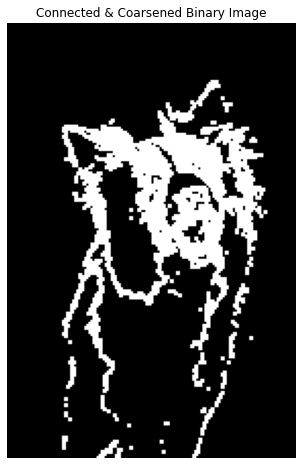

In [9]:
def connect_nearby_lines(binary_image, kernel_size=3, iterations=1):
    """
    Connect nearby lines in a binary image using morphological dilation.

    Args:
        binary_image (numpy.ndarray): Coarsened binary image (1 for paths, 0 for walls).
        kernel_size (int): Size of the kernel used for dilation.
        iterations (int): Number of dilation iterations.

    Returns:
        connected_image (numpy.ndarray): Binary image with connected paths.
    """
    # Create a kernel for dilation
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)

    # Perform dilation to bridge gaps
    dilated = cv2.dilate(binary_image, kernel, iterations=iterations)
    
    # Re-skeletonize to restore thin paths
    # skeleton = cv2.ximgproc.thinning(dilated, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

    return dilated


# Connect nearby lines
connected_image = connect_nearby_lines(coarsened_image, kernel_size=2, iterations=1)

# Display the result
display_image("Connected & Coarsened Binary Image", connected_image)

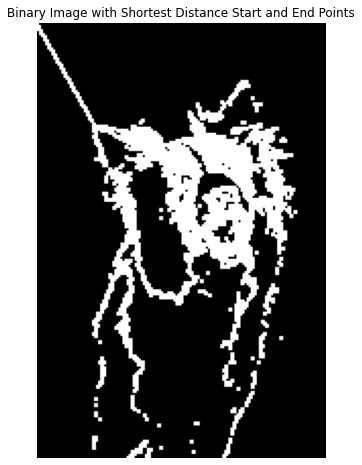

In [10]:
def draw_diagonal_line_with_thickness(binary_image, start, end=None, thickness=2):
    """
    Draw a diagonal line with a specified thickness between two points.
    If `end` is None, draws from the top-left corner to `start`.

    Args:
        binary_image (numpy.ndarray): Binary image (1 for path, 0 for walls).
        start (tuple): Starting point (row, col).
        end (tuple): Ending point (row, col). Defaults to None.
        thickness (int): Thickness of the line.
    """
    if end is None:
        row_start, col_start = 0, 0
        row_end, col_end = start
    else:
        row_start, col_start = start
        row_end, col_end = end

    # Calculate the steps for interpolation
    num_steps = max(abs(row_end - row_start), abs(col_end - col_start))
    row_coords = np.linspace(row_start, row_end, num_steps, dtype=int)
    col_coords = np.linspace(col_start, col_end, num_steps, dtype=int)

    # Set the pixels along the diagonal path with thickness
    for r, c in zip(row_coords, col_coords):
        for dr in range(-thickness, thickness):
            for dc in range(-thickness, thickness):
                rr, cc = r + dr, c + dc
                if 0 <= rr < binary_image.shape[0] and 0 <= cc < binary_image.shape[1]:
                    binary_image[rr, cc] = 1

def find_start_and_end_shortest_distance(binary_image):
    """
    Find start and end points on opposite edges of the binary image based on cardinal distance.

    Args:
        binary_image (numpy.ndarray): Binary image with the solution path.

    Returns:
        (start, end, binary_image): Start and end points with the updated binary image.
    """
    rows, cols = binary_image.shape

    # Initialize variables
    min_distance_start = float('inf')
    start = None

    # Find the point closest to the top-left corner
    for row in range(rows):
        for col in range(cols):
            if binary_image[row, col] == 1:
                # Calculate Manhattan distance to top-left corner
                distance = row + col
                if distance < min_distance_start:
                    min_distance_start = distance
                    start = (row, col)

    # Draw a line from the top-left corner to the start
    if start and start[0] != 0:
        draw_diagonal_line_with_thickness(binary_image, start, thickness=1)

    # Initialize variables for the end
    min_distance_end = float('inf')
    end = None

    # Find the point closest to the bottom-right corner
    for row in range(rows - 1, -1, -1):
        for col in range(cols - 1, -1, -1):
            if binary_image[row, col] == 1:
                # Calculate Manhattan distance to bottom-right corner
                distance = (rows - 1 - row) + (cols - 1 - col)
                if distance < min_distance_end:
                    min_distance_end = distance
                    end = (row, col)

    # Draw a line from the bottom-right corner to the end
    if end and end[0] != rows - 1:
        draw_diagonal_line_with_thickness(binary_image, end, (rows - 1, cols - 1), thickness=2)

    return start, end, binary_image

# Example Usage
start, end, maze = find_start_and_end_shortest_distance(connected_image.copy())

# Visualize the result
plt.figure(figsize=(8, 8))
plt.title("Binary Image with Shortest Distance Start and End Points")
plt.imshow(maze, cmap='gray')
plt.axis('off')
plt.show()

In [11]:
# translate image into graph
# group by connected pixels (4d traversable)
# any group of pixels > X size is "relevant"
# create recursive function creating maze given a beginning and end

In [12]:
def identify_groups(binary_image, threshold):
    """
    Finds all relevant groups within the image. Relevancy determined by threshold.

    Args:
        binary_image (numpy.ndarray): Binary image with the solution path.
        threshold (int): relevant group has >= threshold # of pixels

    Returns:
        list of groups + corresponding size
    """
    rows, cols = binary_image.shape

    visited = set()
    groups = []  # to store groups
    group_sizes = []  # to store sizes of groups

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    for row in range(rows):
        for col in range(cols):
            if (row, col) not in visited and binary_image[row][col] == 1:
                # create new group
                visited.add((row, col))
                queue = deque([(row, col)])
                group = [(row, col)]
                
                while queue:
                    r, c = queue.popleft()
                    group.append((r, c))
                    
                    for dr, dc in directions:
                        rr, cc = r + dr, c + dc
                        if (
                                0 <= rr < rows
                                and 0 <= cc < cols
                                and (rr, cc) not in visited
                                and binary_image[rr, cc] == 1
                            ):
                                queue.append((rr, cc))
                                visited.add((rr, cc))
                
                # add group if it meets the size threshold
                if len(group) >= threshold:
                    groups.append(group)
                    group_sizes.append(len(group))

    return groups, group_sizes

groups, group_sizes = identify_groups(maze, 10)
group_sizes

[4578,
 133,
 17,
 11,
 12,
 58,
 16,
 11,
 35,
 17,
 45,
 36,
 22,
 20,
 22,
 37,
 18,
 24,
 40,
 15]

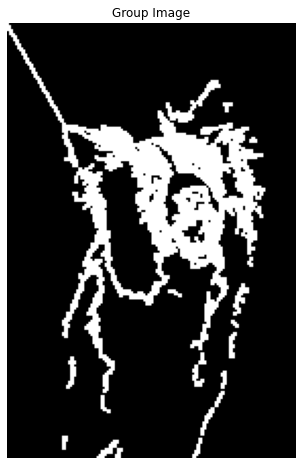

In [13]:
def draw_groups_pixel_by_pixel(binary_image, groups):
    """
    Create a visualization of the identified groups by coloring pixels one by one.

    Args:
        binary_image (numpy.ndarray): Original binary image.
        groups (list of list of tuple): Groups of connected pixels.

    Returns:
        grouped_image (numpy.ndarray): Image with unique values for each group.
    """
    # Initialize a blank canvas
    grouped_image = np.zeros_like(binary_image, dtype=int)

    # Assign unique values to each group and color pixels
    for group in groups:
        for (row, col) in group:
            grouped_image[row, col] = 1

    return grouped_image

grouped_image = draw_groups_pixel_by_pixel(maze, groups)

display_image("Group Image", grouped_image)

In [ ]:
"""
Generates an order for maze population based on cardinal distance 
+ the closest path "linking" each group

Args:
    groups (list of list of tuples): Groups of connected pixels.
    start (int): idx of starting group; default = 0
"""
def find_order_and_links(groups, start=0):
    # fastest way may be an O(n^2) radial search (?) 
    # --> would then want to store all group : pixel info in maps 
    pass

In [ ]:
"""
Creates a subpart of the maze using the given coordinates

Args: 
    subgroup (list of tuples): a list of connected coordinates
    start (int): determined from previous end
    end (int): determined by closest pixel contained in an unvisited group
"""
def gen_maze_subpart(subgroup, start, end):
    pass